In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from utils.preprocessing_util import *
from pandas import DataFrame
from pprint import pprint

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
# Load Datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

flat_model_map=train.groupby('flat_model')['monthly_rent'].mean().to_dict()

In [81]:
def preprocess_location_property_attributes(df:DataFrame) -> DataFrame :
    global flat_model_map
    _df = df.copy()
    # Drop columns with no significance
    _df = _df.drop('furnished', axis=1)
    _df = _df.drop('elevation', axis=1)

    # Numeric encoding
    clean_replace_numeric(_df, 'flat_type', '2', 2)
    clean_replace_numeric(_df, 'flat_type', '3', 3)
    clean_replace_numeric(_df, 'flat_type', '4', 4)
    clean_replace_numeric(_df, 'flat_type', '5', 5)
    clean_replace_numeric(_df, 'flat_type', 'executive', 6)

    # Target encoding
    # target_encode(_df, 'flat_model')
    # format_integer(_df, 'flat_model')

    # Reverse the key-value pairs
    reversed_prices = {v: k for k, v in flat_model_map.items()}

    # Organize based on the "model" prefix
    model_prices = {k: v for k, v in reversed_prices.items()}

    # Sort the models by price
    sorted_models = {v: k for k, v in sorted(model_prices.items(), key=lambda item: item[1], reverse=True)}
    for i,k in zip(range(len(sorted_models.keys())),sorted_models.keys()):
        sorted_models[k] =i
    # Create the final dictionary with "model" as key and "rank_by_price" as value
    _df['flat_model'] = _df['flat_model'].apply(lambda row:flat_model_map[row])

    # OnehotEnoding
    _df = pd.concat([generate_dummies(_df, 'town'),
               _df,
          ], axis=1)

    return _df

def preprocess_rent_date(df:DataFrame) -> DataFrame :
    _df =df.copy()

    # rent year and month
    _df['rent_approval_year'] = pd.to_datetime(_df['rent_approval_date']).dt.year
    _df['rent_approval_month'] = pd.to_datetime(_df['rent_approval_date']).dt.month

    # age of house when rental begin
    _df['age_at_rental_start'] = _df['rent_approval_year'] - _df['lease_commence_date']
    
    _df = _df.drop(columns=['rent_approval_date','lease_commence_date'])
    return _df

def preprocess_geographic_location(df:DataFrame) -> DataFrame :
    _df =df.copy()
    mrt_exist_df = pd.read_csv('../auxiliary-data/sg-mrt-existing-stations.csv')
    mrt_planned_df = pd.read_csv('../auxiliary-data/sg-mrt-planned-stations.csv')
    primary_school_df = pd.read_csv('../auxiliary-data/sg-primary-schools.csv')
    # Calculate distances for each row in df
    _df['dist_mrt_exist'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], mrt_exist_df), axis=1)
    _df['dist_mrt_planned'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], mrt_planned_df), axis=1)
    _df['dist_primary_school'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], primary_school_df), axis=1)
    return _df

def preprocess_subzone_planning_area_region(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def preprocess_others1(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def remove_columns(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def preprocess(df:DataFrame) -> DataFrame:
    _df = df.copy()

    # Proprocess property location attributes
    _df = preprocess_location_property_attributes(_df)

    # Process rent approval date data
    _df = preprocess_rent_date(_df)

    _df=preprocess_geographic_location(_df)

    _df=preprocess_subzone_planning_area_region(_df)

    _df=preprocess_others1(_df)

    _df=remove_columns(_df)

    return _df

In [82]:
# geographic calc take 1min10s+
df = preprocess(train)

In [83]:
df.head(2).T

,0,1
town_bedok,False,True
town_bishan,False,False
town_bukit batok,False,False
town_bukit merah,False,False
town_bukit panjang,False,False
town_bukit timah,False,False
town_central,False,False
town_choa chu kang,False,False
town_clementi,False,False
town_geylang,False,False


In [84]:
X_train = df.drop(columns=['street_name','block','town','region','planning_area','subzone','latitude','longitude','monthly_rent'])
y_train = df['monthly_rent']

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   town_bedok            60000 non-null  bool   
 1   town_bishan           60000 non-null  bool   
 2   town_bukit batok      60000 non-null  bool   
 3   town_bukit merah      60000 non-null  bool   
 4   town_bukit panjang    60000 non-null  bool   
 5   town_bukit timah      60000 non-null  bool   
 6   town_central          60000 non-null  bool   
 7   town_choa chu kang    60000 non-null  bool   
 8   town_clementi         60000 non-null  bool   
 9   town_geylang          60000 non-null  bool   
 10  town_hougang          60000 non-null  bool   
 11  town_jurong east      60000 non-null  bool   
 12  town_jurong west      60000 non-null  bool   
 13  town_kallang/whampoa  60000 non-null  bool   
 14  town_marine parade    60000 non-null  bool   
 15  town_pasir ris     

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [87]:
kf =KFold(n_splits=5)

# Define a custom scoring function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

def get_RMSE(clf, x, y):
    
    avg_RMSE = cross_val_score(clf, x, y, scoring=scorer, cv=kf, n_jobs=-1).mean()*-1
    return (avg_RMSE)


In [88]:
pipe_preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',StandardScaler())
])



In [93]:
pipe_RFR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', RandomForestRegressor(max_depth=10,max_features=0.5,n_estimators=300))
])

pipe_GBR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', GradientBoostingRegressor(learning_rate=0.05,max_depth=6,min_samples_leaf=3,n_estimators=300))
])

pipe_LGB = Pipeline([('preprocessor', pipe_preprocess),
                     ('classifier', lgb.LGBMRegressor(objective='regression',
                                                       metric='rmse',
                                                       n_estimators=150,
                                                       learning_rate=0.05,
                                                       max_depth=9,
                                                       num_leaves= 70,
                                                       random_state=0))])

GB = pipe_GBR
RF = pipe_RFR
LGB = pipe_LGB

estimators = [
    ('GB',GB),
    ('RF',RF),
    ('LGB',LGB),
]

final_estimator = lgb.LGBMRegressor(objective='regression',
                                                       metric='rmse',
                                                       learning_rate=0.05,
                                                       max_depth=3,
                                                       n_estimators=100,
                                                       random_state=0,
                                                       num_leaves= 2**3
                                                       )

stacking_classifier = StackingRegressor(estimators=estimators,cv=5,
                                         final_estimator=final_estimator, n_jobs=-1)


stacking_classifier.fit(X_train,y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 2590.328333


StackingRegressor(cv=10,
                  estimators=[('GB',
                               Pipeline(steps=[('preprocess',
                                                Pipeline(steps=[('imputer',
                                                                 SimpleImputer(strategy='most_frequent')),
                                                                ('scaler',
                                                                 StandardScaler())])),
                                               ('classifier',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          max_depth=6,
                                                                          min_samples_leaf=3,
                                                                          n_estimators=300))])),
                              ('RF',
                               Pipeline(steps=[('preprocess',
                                                Pipeline(steps=[('imputer',
                                                                 Simp...
                                                                 SimpleImputer(strategy='most_frequent')),
                                                                ('scaler',
                                                                 StandardScaler())])),
                                               ('classifier',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=9,
                                                              metric='rmse',
                                                              n_estimators=300,
                                                              num_leaves=80,
                                                              objective='regression',
                                                              random_state=0))]))],
                  final_estimator=LGBMRegressor(learning_rate=0.05, max_depth=3,
                                                metric='rmse', n_estimators=300,
                                                num_leaves=6,
                                                objective='regression',
                                                random_state=0),
                  n_jobs=-1)

In [90]:
X_test = preprocess(test).drop(columns=['street_name','block','town','region','planning_area','subzone','latitude','longitude'])


In [94]:
y_predict = stacking_classifier.transform(X_test)

In [95]:
pd.DataFrame(y_predict.mean(axis=1),columns=['Predicted']).reset_index().rename(columns={'index':'Id'}).to_csv('result.csv',index=False)

### EDA only

### Monthly rent distribution for kfold=5

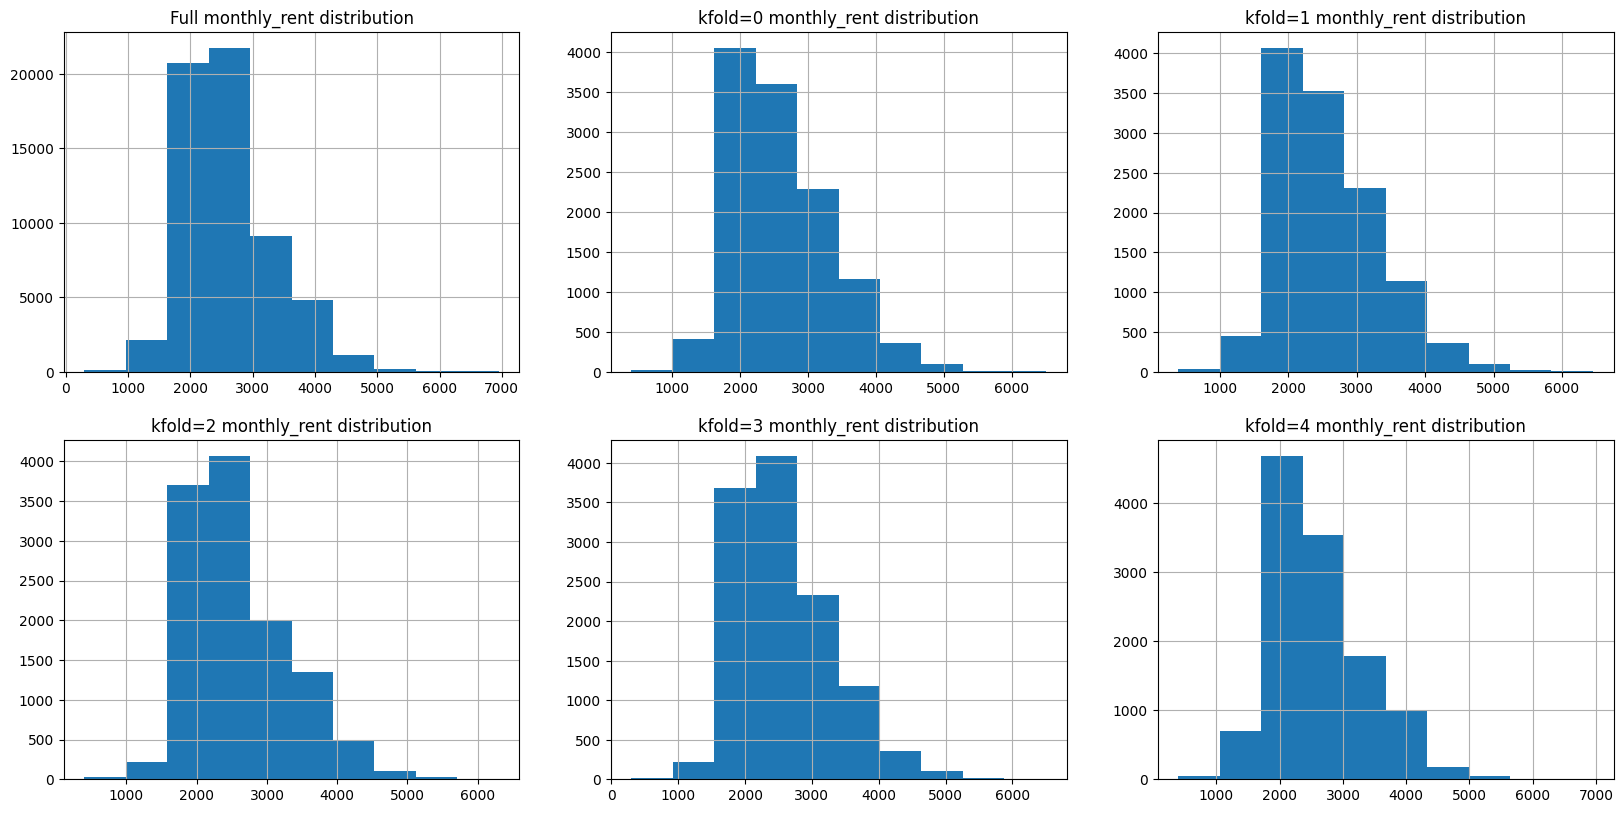

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(3,3,1)
df['monthly_rent'].hist()
plt.title('Full monthly_rent distribution')
for i in range(5):    
    plt.subplot(3,3,i+2)
    df[df['kfold'] == i]['monthly_rent'].hist()
    plt.title(f'kfold={i} monthly_rent distribution')